In [ ]:
#  Installation des librairies
!pip install numpy pandas geopandas matplotlib

In [ ]:
# Importation des librairies
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import os

# 1. Manipulation des Données avec Pandas

In [12]:
# Définition des fonctions

def load_and_clean_data(file):
    # Charger un jeu de données CSV contenant des informations sur des villes, comprenant les colonnes ⁠ ville⁠, ⁠pays⁠, population⁠, ⁠latitude⁠ et⁠ longitude ⁠.
    villes = pd.read_csv(file)

    # Nettoyer les données en traitant les valeurs manquantes et en filtrant les données incorrectes.
    villes = villes.dropna(subset=['ville', 'pays', 'population', 'latitude', 'longitude'])

    return villes

# Calculer des statistiques descriptives sur la population des villes
def calculate_statistics(dataframe):
    return dataframe['population'].describe()

In [16]:
# Importation des données
villes_df = load_and_clean_data('villes.csv')

# Visualisation du jeu de données CSV
villes_df.head()

,ville,latitude,longitude,pays,population
0,Tokyo,35.6897,139.6922,Japan,37732000.0
1,Jakarta,-6.1750,106.8275,Indonesia,33756000.0
2,Delhi,28.6100,77.2300,India,32226000.0
3,Guangzhou,23.1300,113.2600,China,26940000.0
4,Mumbai,19.0761,72.8775,India,24973000.0


In [17]:
# Calculer des statistiques descriptives sur la population des villes
calculate_statistics(villes_df)

,population
count,9.900000e+01
mean,1.150485e+07
std,6.575841e+06
min,5.708191e+06
25%,6.989618e+06
50%,8.970014e+06
75%,1.439650e+07
max,3.773200e+07


# 2. Analyse Géospatiale avec GeoPandas

In [18]:
# Définition des fonctions

# Convertir le DataFrame Pandas en GeoDataFrame GeoPandas en utilisant les colonnes ⁠latitude ⁠et ⁠longitude
def convert_to_geodataframe(dataframe):
    gdf = gpd.GeoDataFrame(
        dataframe,
        geometry=gpd.points_from_xy(dataframe['longitude'], dataframe['latitude']),
        crs="EPSG:4326"  # Projection standard WGS84
    )
    return gdf

def spatial_join_cities_countries(cities_gdf, countries_shp):
    # Charger un fichier shapefile contenant les frontières des pays
    countries = gpd.read_file(countries_shp)
    # Définir le système de coordonnées approprié
    countries.set_crs("EPSG:4326", inplace=True)
    # S'assurer que le GeoDataFrame des villes est dans le même système de coordonnées que celui des pays
    cities_gdf = cities_gdf.to_crs(countries.crs)
    # Effectuer une jointure spatiale entre les villes et les frontières des pays pour déterminer dans quel pays se trouve chaque ville.
    joined = gpd.sjoin(cities_gdf, countries, how="inner", predicate='within')

    return joined

In [19]:
# Convertir le DataFrame
villes_gdf = convert_to_geodataframe(villes_df)

# Visualisation du jeu de données
villes_gdf.head()

,ville,latitude,longitude,pays,population,geometry
0,Tokyo,35.6897,139.6922,Japan,37732000.0,POINT (139.6922 35.6897)
1,Jakarta,-6.1750,106.8275,Indonesia,33756000.0,POINT (106.8275 -6.175)
2,Delhi,28.6100,77.2300,India,32226000.0,POINT (77.23 28.61)
3,Guangzhou,23.1300,113.2600,China,26940000.0,POINT (113.26 23.13)
4,Mumbai,19.0761,72.8775,India,24973000.0,POINT (72.8775 19.0761)


In [21]:
pays_shp = 'pays.shp'

# Effectuer une jointure spatiale
villes_avec_pays = spatial_join_cities_countries(villes_gdf, pays_shp)

# Visualisation du jeu de données
print(villes_avec_pays.head())

       ville  latitude  longitude       pays  population  \
0      Tokyo   35.6897   139.6922      Japan  37732000.0   
1    Jakarta   -6.1750   106.8275  Indonesia  33756000.0   
2      Delhi   28.6100    77.2300      India  32226000.0   
3  Guangzhou   23.1300   113.2600      China  26940000.0   
4     Mumbai   19.0761    72.8775      India  24973000.0   

                   geometry  index_right  
0  POINT (139.6922 35.6897)          189  
1   POINT (106.8275 -6.175)            0  
2       POINT (77.23 28.61)            8  
3      POINT (113.26 23.13)            9  
4   POINT (72.8775 19.0761)            8  


# 3. Visualisation des Données

In [22]:
# Définition des fonctions

def visualize_data(cities_gdf, countries_shp):
    # Charger les frontières des pays
    countries_gdf = gpd.read_file(countries_shp)

    # Vérifier que les CRS sont compatibles
    countries_gdf.set_crs("EPSG:4326", inplace=True)  # Remplacez par le CRS approprié
    cities_gdf.set_crs("EPSG:4326", inplace=True)     # Remplacez par le CRS approprié

    # Préparer la figure et les axes
    fig, ax = plt.subplots(figsize=(12, 8))

    # Visualiser les frontières des pays
    countries_gdf.plot(ax=ax, edgecolor="black", facecolor="none")

    # Visualiser les villes avec une coloration basée sur la population
    cities_gdf.plot(
        ax=ax,
        column='population',  # Utilisez 'column' pour indiquer la colonne à utiliser pour la coloration
        marker='o',
        cmap='viridis',
        legend=True,
        legend_kwds={'label': "Population des villes", 'shrink': 0.5}
    )

    # Ajouter un titre et afficher
    plt.title("Visualisation des villes et des pays")
    plt.show()


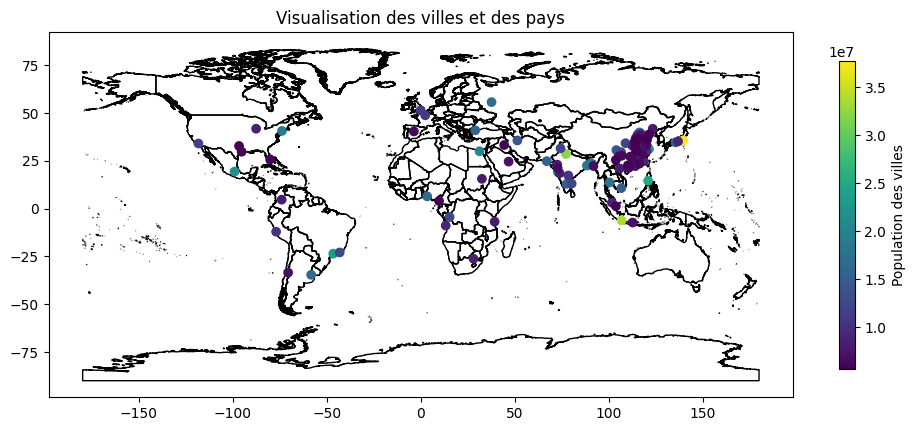

In [23]:
# Visualisation
visualize_data(villes_gdf, pays_shp)

# 4. Tests Unitaires

In [24]:
# Écrire des tests unitaires pour vérifier les fonctions de manipulation des données
def test_load_and_clean_data():
    # Création de données de test
    test_file = "test_data.csv"
    data = {
        'ville': ['Paris', 'Londres', None],
        'pays': ['France', 'UK', 'France'],
        'population': [2000, 3000, None],
        'latitude': [48.8566, 51.5074, 48.8566],
        'longitude': [2.3522, -0.1276, 2.3522]
    }
    df = pd.DataFrame(data)
    df.to_csv(test_file, index=False)

    # Exécution de la fonction à tester
    cleaned_df = load_and_clean_data(test_file)

    # Visualiser la table
    print(cleaned_df, "\n")

    # Vérifications
    assert len(cleaned_df) == 2, "La fonction doit supprimer les lignes avec des valeurs manquantes"
    assert 'ville' in cleaned_df.columns, "La colonne 'ville' devrait être présente dans les données nettoyées"
    assert 'population' in cleaned_df.columns, "La colonne 'population' devrait être présente"
    assert cleaned_df['ville'].iloc[0] == 'Paris', "La première ville après nettoyage devrait être 'Paris'"
    assert cleaned_df['ville'].iloc[1] == 'Londres', "La deuxième ville après nettoyage devrait être 'Londres'"

    print("Tous les tests sont passés avec succès !")

# Exécuter les tests unitaires
test_load_and_clean_data()


     ville    pays  population  latitude  longitude
0    Paris  France      2000.0   48.8566     2.3522
1  Londres      UK      3000.0   51.5074    -0.1276 

Tous les tests sont passés avec succès !


In [25]:
# Écrire des tests unitaires pour vérifier les fonctions de jointure spatiale
def test_spatial_join_cities_countries():
    # Création des données fictives pour les villes
    cities_data = {
        'ville': ['Ville1', 'Ville2'],
        'geometry': [Point(2.3522, 48.8566), Point(-0.1276, 51.5074)],  # Coordonnées fictives
    }
    cities_gdf = gpd.GeoDataFrame(cities_data, crs="EPSG:4326")

    # Création des données fictives pour les pays
    countries_data = {
        'pays': ['Pays1', 'Pays2'],
        'geometry': [
            Polygon([(-5, 40), (10, 40), (10, 55), (-5, 55), (-5, 40)]),  # Europe fictive
            Polygon([(-10, -5), (10, -5), (10, 5), (-10, 5), (-10, -5)])  # Afrique fictive
        ]
    }
    countries_gdf = gpd.GeoDataFrame(countries_data, crs="EPSG:4326")
    countries_shp = "test_countries.shp"

    # Sauvegarder les données fictives dans un fichier temporaire shapefile
    countries_gdf.to_file(countries_shp)

    # Exécution de la fonction à tester
    result = spatial_join_cities_countries(cities_gdf, countries_shp)

    # Visualiser la table
    print(result, "\n")

    # Vérifications
    assert len(result) == 2, "La jointure spatiale devrait contenir deux correspondances."
    assert 'pays' in result.columns, "La colonne 'pays' devrait être présente dans le résultat."
    assert result.loc[result['ville'] == 'Ville1', 'pays'].values[0] == 'Pays1', \
        "Ville1 devrait être associée à Pays1."
    assert result.loc[result['ville'] == 'Ville2', 'pays'].values[0] == 'Pays1', \
        "Ville2 devrait être associée à Pays1."

    print("Tous les tests sont passés avec succès !")

# Exécuter les tests unitaires
test_spatial_join_cities_countries()


    ville                 geometry  index_right   pays
0  Ville1   POINT (2.3522 48.8566)            0  Pays1
1  Ville2  POINT (-0.1276 51.5074)            0  Pays1 

Tous les tests sont passés avec succès !
